In [1]:
import sys
sys.path.append('../')
path_data = '/home/jaime/projects/Dropbox_project/projects/kaggle/Housing_prices_course/data/'

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [41]:
def type_and_nulls(df):
    df_type = pd.concat([pd.DataFrame(df.dtypes), df.isnull().sum().to_frame().rename(columns={0:'nulls'})], axis=1)
    display(df_type.head())
    display(df.dtypes.value_counts())
    not_nulls = list((df_type[df_type['nulls']==0]).index)
    nulls = list((df_type[df_type['nulls']>0]).index)
    
    dict_type_columns = {}
    for type_column in list(df.dtypes.value_counts().index):
        dict_type_columns[str(type_column)] = list(df_type[df_type[0] == type_column].index)
    
    print('Nulls features: ', len(nulls))
    print('Not null features: ', len(not_nulls))
    
    dict_type_columns['nulls'] = nulls
    dict_type_columns['not_nulls'] = not_nulls
    
    
    return dict_type_columns, df_type


def correlation_heatmap(df, columns, figsize=(12, 9), plot=False):
    corrmat = df[columns].corr()
    sorted_columns = corrmat.sum(axis=1).sort_values().index.values
    corrmat = corrmat.loc[sorted_columns][sorted_columns]
    if plot:
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corrmat, vmax=.8, square=True)
    return corrmat

def polynomial_transformations(df_train, columns, degree=2, scale_method=None):
    if scale_method is not None:
        df_train, df_val = apply_scale(df_train[columns], df_val[columns], scale_method)
    poly_trans = PolynomialFeatures(degree=degree)
    df_result_train = pd.DataFrame(poly_trans.fit_transform(df_train[columns]))
        
    df_result_train.columns = poly_trans.get_feature_names_out()
    
    return df_result_train

def select_complex_features(x_train_local, y_train_local, x_val_local, y_val_local, target):
    
    list_metrics = [] 
    
    corr_target = correlation_heatmap(pd.concat([x_train_local, pd.DataFrame(y_train_local)], axis=1), 
                                      pd.concat([x_train_local, pd.DataFrame(y_train_local)], axis=1).columns)
    
    for num_best_features in np.arange(1, x_train_local.shape[1]+1, 1):
        
        high_corr_features_exp_1 = list(corr_target[target].sort_values(ascending=False)[1:num_best_features+1].index)        
                
        df_polyn_train =  polynomial_transformations(x_train_local, high_corr_features_exp_1, degree=2)
        df_polyn_val =  polynomial_transformations(x_val_local, high_corr_features_exp_1, degree=2)


        lr = LinearRegression().fit(df_polyn_train.values, y_train_local.values)

        y_predict_train = lr.predict(df_polyn_train.values)
        y_predict_val = lr.predict(df_polyn_val.values)

        metric_train_pol = mean_squared_error(y_predict_train, y_train_local.values)
        metric_val_pol = mean_squared_error(y_predict_val, y_val_local.values)   

        list_metrics.append([num_best_features, metric_val_pol]) 
        
#         print(num_best_features, corr_target.shape)
#         print(high_corr_features_exp_1)
#         print(metric_val_pol)
#         print()
        
    min_index = np.argmin(np.array(list_metrics)[:, 1], 0)
    return list_metrics[min_index][0]
    

In [15]:
df_train = pd.read_csv(path_data+'train.csv', index_col='Id')
df_test = pd.read_csv(path_data+'test.csv', index_col='Id')

In [16]:
dict_type_columns, df_type = type_and_nulls(df_train)

,0,nulls
MSSubClass,int64,0
MSZoning,object,0
LotFrontage,float64,259
LotArea,int64,0
Street,object,0


object     43
int64      34
float64     3
dtype: int64

Nulls features:  19
Not null features:  61


In [17]:
dict_type_columns.keys()

dict_keys(['object', 'int64', 'float64', 'nulls', 'not_nulls'])

In [18]:
numerical_features_not_null = set(dict_type_columns['int64'] + dict_type_columns['float64']) - set(dict_type_columns['nulls'])
numerical_features_not_null = list(numerical_features_not_null)
target = numerical_features_not_null.pop(numerical_features_not_null.index('SalePrice'))
len(numerical_features_not_null)
print(target)
print(len(numerical_features_not_null), numerical_features_not_null)

SalePrice
33 ['LowQualFinSF', 'WoodDeckSF', 'KitchenAbvGr', 'BsmtFinSF2', 'MiscVal', '1stFlrSF', 'OverallCond', 'YearBuilt', 'HalfBath', 'PoolArea', 'EnclosedPorch', 'GarageCars', 'MSSubClass', 'LotArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', 'BsmtHalfBath', 'GarageArea', 'Fireplaces', 'YrSold', 'BsmtFinSF1', 'BsmtUnfSF', '3SsnPorch', 'YearRemodAdd', 'BsmtFullBath', 'BedroomAbvGr', '2ndFlrSF', 'OpenPorchSF', 'FullBath', 'ScreenPorch', 'TotRmsAbvGrd', 'MoSold']


In [19]:
df_train[numerical_features_not_null].describe()

,LowQualFinSF,WoodDeckSF,KitchenAbvGr,BsmtFinSF2,MiscVal,1stFlrSF,OverallCond,YearBuilt,HalfBath,PoolArea,...,3SsnPorch,YearRemodAdd,BsmtFullBath,BedroomAbvGr,2ndFlrSF,OpenPorchSF,FullBath,ScreenPorch,TotRmsAbvGrd,MoSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,5.844521,94.244521,1.046575,46.549315,43.489041,1162.626712,5.575342,1971.267808,0.382877,2.758904,...,3.409589,1984.865753,0.425342,2.866438,346.992466,46.660274,1.565068,15.060959,6.517808,6.321918
std,48.623081,125.338794,0.220338,161.319273,496.123024,386.587738,1.112799,30.202904,0.502885,40.177307,...,29.317331,20.645407,0.518911,0.815778,436.528436,66.256028,0.550916,55.757415,1.625393,2.703626
min,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,1.000000,1872.000000,0.000000,0.000000,...,0.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,882.000000,5.000000,1954.000000,0.000000,0.000000,...,0.000000,1967.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,5.000000,5.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1087.000000,5.000000,1973.000000,0.000000,0.000000,...,0.000000,1994.000000,0.000000,3.000000,0.000000,25.000000,2.000000,0.000000,6.000000,6.000000
75%,0.000000,168.000000,1.000000,0.000000,0.000000,1391.250000,6.000000,2000.000000,1.000000,0.000000,...,0.000000,2004.000000,1.000000,3.000000,728.000000,68.000000,2.000000,0.000000,7.000000,8.000000
max,572.000000,857.000000,3.000000,1474.000000,15500.000000,4692.000000,9.000000,2010.000000,2.000000,738.000000,...,508.000000,2010.000000,3.000000,8.000000,2065.000000,547.000000,3.000000,480.000000,14.000000,12.000000


In [25]:
target = 'SalePrice'

## Split training and test datasets
X_train, X_test = train_test_split(df_train[numerical_features_not_null+[target]], test_size=0.4, random_state=0)
Y_train = X_train.pop(target)
Y_test = X_test.pop(target)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((876, 33), (876,), (584, 33), (584,))

In [26]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train.columns = numerical_features_not_null

X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test.columns = numerical_features_not_null   

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((876, 33), (876,), (584, 33), (584,))

In [27]:
target = 'SalePrice'
## experiment parameters 
num_best_features = 10
K_folds = 5


## Using train/val partition

In [30]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.4, random_state=0)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((525, 33), (525,), (351, 33), (351,))

In [45]:
y_train

Id
1023     87000
974     182000
273     290000
333     284000
431      85400
         ...  
544     133000
211      98000
169     183500
349     154000
813      55993
Name: SalePrice, Length: 525, dtype: int64

In [44]:
x_train

,LowQualFinSF,WoodDeckSF,KitchenAbvGr,BsmtFinSF2,MiscVal,1stFlrSF,OverallCond,YearBuilt,HalfBath,PoolArea,...,3SsnPorch,YearRemodAdd,BsmtFullBath,BedroomAbvGr,2ndFlrSF,OpenPorchSF,FullBath,ScreenPorch,TotRmsAbvGrd,MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1023,-0.105753,-0.747190,-0.197286,-0.306291,-0.093782,-0.678217,-0.507348,-1.377512,-0.757327,-0.057916,...,-0.116071,-1.700917,-0.804210,-1.110430,-0.038003,-0.700933,-1.075421,-0.277207,-0.346792,-1.212338
974,-0.105753,-0.747190,-0.197286,-0.306291,-0.093782,0.685743,-0.507348,1.178213,-0.757327,-0.057916,...,-0.116071,1.137744,-0.804210,0.135071,-0.794240,1.063443,0.764557,-0.277207,-0.346792,2.155553
273,-0.105753,0.263314,-0.197286,-0.306291,-0.093782,-0.012097,1.314114,0.912683,1.259143,-0.057916,...,-0.116071,1.088802,-0.804210,1.380573,1.695041,0.137145,0.764557,-0.277207,1.505585,-0.838128
333,-0.105753,-0.747190,-0.197286,2.672249,-0.093782,1.217053,-0.507348,1.045448,-0.757327,-0.057916,...,-0.116071,0.941974,1.136528,0.135071,-0.794240,-0.700933,0.764557,-0.277207,0.270667,1.407133
431,-0.105753,-0.747190,-0.197286,-0.306291,-0.093782,-1.812207,-0.507348,-0.016671,1.259143,-0.057916,...,-0.116071,-0.673126,-0.804210,-1.110430,0.340116,-0.700933,-1.075421,-0.277207,-1.581710,0.284502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,-0.105753,0.171450,-0.197286,0.558045,-0.093782,-1.061500,-0.507348,0.879492,-0.757327,-0.057916,...,-0.116071,0.648320,1.136528,-2.355931,-0.794240,-0.112808,-1.075421,-0.277207,-1.581710,-0.089708
211,-0.105753,-0.747190,-0.197286,-0.306291,-0.093782,-0.805097,0.403383,-1.543468,-0.757327,-0.057916,...,-0.116071,-1.700917,1.136528,-1.110430,-0.794240,-0.700933,-1.075421,-0.277207,-0.964251,-0.838128
169,-0.105753,0.018343,-0.197286,-0.306291,-0.093782,-0.868537,-0.507348,1.078639,1.259143,-0.057916,...,-0.116071,0.941974,-0.804210,0.135071,1.186381,0.004817,0.764557,-0.277207,0.270667,-0.463918


In [61]:
num_features = select_complex_features(x_train, y_train, x_val, y_val, target)
num_features

5

In [82]:
## Estimate alpha
list_estimation = []
for alpha in [0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

    corr_target = correlation_heatmap(pd.concat([X_train, pd.DataFrame(Y_train)], axis=1), 
                                      list(X_train.columns)+[target])
    high_corr_features_exp_1 = list(corr_target[target].sort_values(ascending=False)[1:num_features+1].index)        


    df_polyn_train =  polynomial_transformations(x_train, high_corr_features_exp_1, degree=2)
    df_polyn_val =  polynomial_transformations(x_val, high_corr_features_exp_1, degree=2)


    # lr = LinearRegression().fit(df_polyn_train.values, Y_train.values)
    lr = Ridge(alpha=alpha).fit(df_polyn_train.values, y_train.values)


    y_predict_train = lr.predict(df_polyn_train.values)
    y_predict_val = lr.predict(df_polyn_val.values)

    metric_train = mean_squared_error(y_predict_train, y_train.values)
    metric_val = mean_squared_error(y_predict_val, y_val.values) 
    
    list_estimation.append([alpha, metric_train, metric_val])


In [83]:
df_metric_exp_1 = pd.DataFrame(list_estimation)
df_metric_exp_1.columns = ['alpha', 'metric_train', 'metric_val']
df_metric_exp_1.sort_values('metric_val')

,alpha,metric_train,metric_val
10,64.00,1.210347e+09,9.419202e+08
11,128.00,1.272775e+09,9.455951e+08
9,32.00,1.179609e+09,9.590379e+08
8,16.00,1.165100e+09,9.804447e+08
7,8.00,1.158621e+09,9.987686e+08
12,256.00,1.396786e+09,1.001337e+09
6,4.00,1.156017e+09,1.011971e+09
5,2.00,1.155108e+09,1.020389e+09
4,1.00,1.154828e+09,1.025273e+09
3,0.80,1.154791e+09,1.026317e+09


In [70]:
df_metric_exp_1.sort_values('metric_val')

,alpha,metric_train,metric_val
4,1.00,1.154828e+09,1.025273e+09
3,0.80,1.154791e+09,1.026317e+09
2,0.50,1.154749e+09,1.027930e+09
1,0.25,1.154728e+09,1.029320e+09
0,0.01,1.154721e+09,1.030696e+09


In [58]:
print(1.16636811e+09)

1166368110.0


## Using cross validation

In [111]:
# scoring='neg_mean_squared_error'
# def my_custom_loss_func(y_true, y_pred):
#     diff = np.abs(y_true - y_pred).max()
#     return np.log1p(diff)

# mse_score = make_scorer(mean_squared_error, greater_is_better=False)
# msle_score = make_scorer(mean_squared_log_error, greater_is_better=False)
# mape_score = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


# lr = LinearRegression().fit(x_train[high_corr_features_exp_1].values, x_train[[target]].values)

# one score
# scores = cross_val_score(lr, x_train[high_corr_features_exp_1].values,
#                              x_train[[target]].values, cv=kf, scoring=mse_score)
# several scores
# scores = cross_validate(lr, x_train[high_corr_features_exp_1].values,
#                                 x_train[[target]].values, cv=kf, scoring={'mse_score':mse_score, 
#                                                                           'mape_score':mape_score
#                                                                          })

# np.mean(scores), np.std(scores)

In [84]:
kf = KFold(n_splits=K_folds, shuffle=True, random_state=21)

In [57]:
list_estimation_cv = []
for alpha in [0.01, 0.25, 0.5, 0.8, 1.0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

    list_metrics_exp_1 = []
    for fold, (index_train, index_val) in enumerate(kf.split(X_train)):
        print(fold, 'idx_train: ',index_train.shape, ' idx_val:',index_val.shape)  

        num_features = select_complex_features(X_train.iloc[index_train], 
                                               Y_train.iloc[index_train], 
                                               X_train.iloc[index_val], 
                                               Y_train.iloc[index_val], target)    

        corr_target = correlation_heatmap(pd.concat([X_train.iloc[index_train], 
                                                     Y_train.iloc[index_train]], axis=1), 
                                          list(X_train.columns)+[target])
        high_corr_features_exp_1 = list(corr_target[target].sort_values(ascending=False)[1:num_features+1].index)        


        df_polyn_train =  polynomial_transformations(X_train.iloc[index_train], high_corr_features_exp_1, degree=2)
        df_polyn_val =  polynomial_transformations(X_train.iloc[index_val], high_corr_features_exp_1, degree=2)

        lr = LinearRegression().fit(df_polyn_train.values, Y_train.iloc[index_train].values)

        y_predict_train = lr.predict(df_polyn_train.values)
        y_predict_val = lr.predict(df_polyn_val.values )

        metric_train = mean_squared_error(y_predict_train, Y_train.iloc[index_train].values)
        metric_val = mean_squared_error(y_predict_val, Y_train.iloc[index_val].values)

        list_metrics_exp_1.append([metric_train, metric_val])
        print(num_features, metric_train, metric_val)
        print('--------------')

    print('metric train/test: ', np.mean(list_metrics_exp_1, axis=0))
    print('std train/test: ', np.std(list_metrics_exp_1, axis=0))
    
    list_estimation_cv.append([alpha, np.mean(list_metrics_exp_1, axis=0)])

0 idx_train:  (700,)  idx_val: (176,)
5 1076921070.0334547 855964060.6109885
--------------
1 idx_train:  (701,)  idx_val: (175,)
8 985683062.0810264 810026590.7603184
--------------
2 idx_train:  (701,)  idx_val: (175,)
12 650779859.821689 1001310647.4598935
--------------
3 idx_train:  (701,)  idx_val: (175,)
4 1008582520.7333739 2170927781.0141153
--------------
4 idx_train:  (701,)  idx_val: (175,)
13 568191903.9872975 993611476.6022084
--------------
metric train/test:  [8.58031683e+08 1.16636811e+09]
std train/test:  [2.06801068e+08 5.07850156e+08]


In [60]:
## Train a final model
num_features = 13
corr_target = correlation_heatmap(pd.concat([X_train, pd.DataFrame(Y_train)], axis=1), 
                                  list(X_train.columns)+[target])
high_corr_features_exp_1 = list(corr_target[target].sort_values(ascending=False)[1:num_features+1].index)        


df_polyn_train =  polynomial_transformations(X_train, high_corr_features_exp_1, degree=2)
df_polyn_test =  polynomial_transformations(X_test, high_corr_features_exp_1, degree=2)


lr = LinearRegression().fit(df_polyn_train.values, Y_train.values)

y_predict_train = lr.predict(df_polyn_train.values)
y_predict_test = lr.predict(df_polyn_test.values)

metric_train = mean_squared_error(y_predict_train, Y_train.values)
metric_test = mean_squared_error(y_predict_test, Y_test.values)   

print(metric_train, metric_test)

675815218.723227 4.7640217327922364e+32


## Procedure 2

In [114]:
list_metrics = []
list_features = []

In [115]:
kf = KFold(n_splits=K_folds, shuffle=True, random_state=21)

0 idx_train:  (700,)  idx_val: (176,)
['1stFlrSF' 'FullBath' 'GarageArea' 'GarageCars' 'GrLivArea' 'OverallQual'
 'TotRmsAbvGrd' 'TotalBsmtSF' 'YearBuilt' 'YearRemodAdd']
923979303.2685252
--------------
1 idx_train:  (701,)  idx_val: (175,)
['1stFlrSF' 'FullBath' 'GarageArea' 'GarageCars' 'GrLivArea' 'OverallQual'
 'TotRmsAbvGrd' 'TotalBsmtSF' 'YearBuilt' 'YearRemodAdd']
1064324909.4079179
--------------
2 idx_train:  (701,)  idx_val: (175,)
['1stFlrSF' 'FullBath' 'GarageArea' 'GarageCars' 'GrLivArea' 'OverallQual'
 'TotRmsAbvGrd' 'TotalBsmtSF' 'YearBuilt' 'YearRemodAdd']
1220129445.0722108
--------------
3 idx_train:  (701,)  idx_val: (175,)
['1stFlrSF' 'FullBath' 'GarageArea' 'GarageCars' 'GrLivArea' 'OverallQual'
 'TotRmsAbvGrd' 'TotalBsmtSF' 'YearBuilt' 'YearRemodAdd']
2075623652.5998266
--------------
4 idx_train:  (701,)  idx_val: (175,)
['1stFlrSF' 'FullBath' 'GarageArea' 'GarageCars' 'GrLivArea' 'OverallQual'
 'TotRmsAbvGrd' 'TotalBsmtSF' 'YearBuilt' 'YearRemodAdd']
1384413440

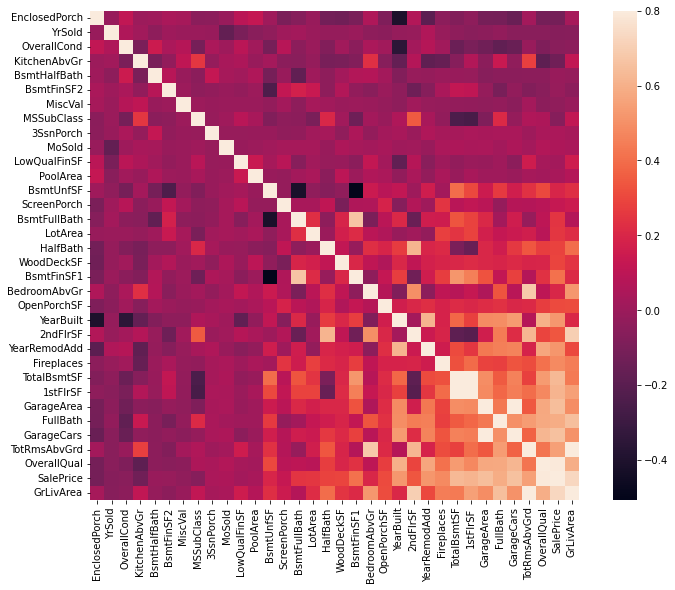

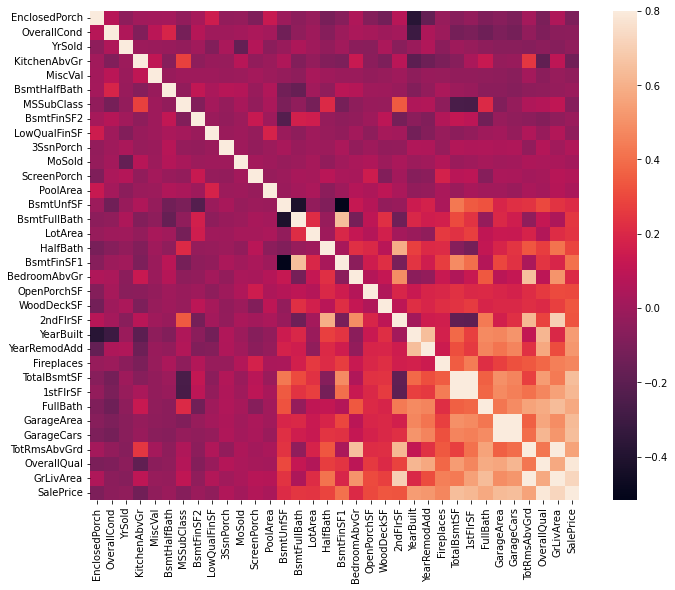

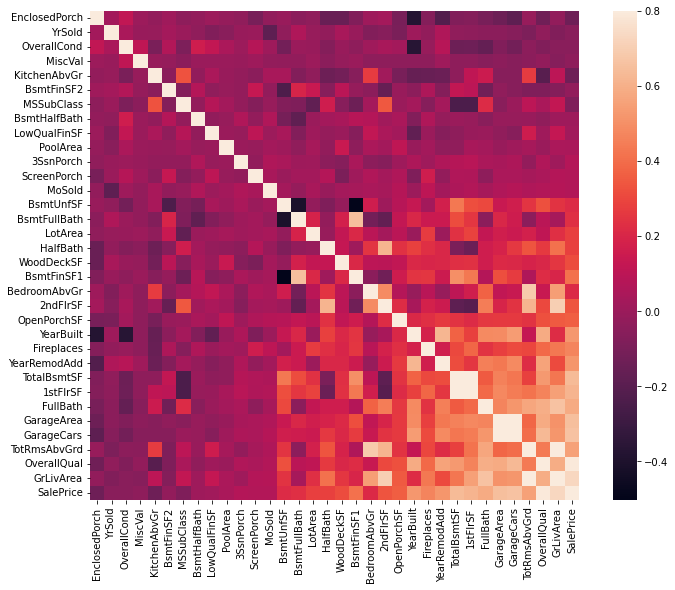

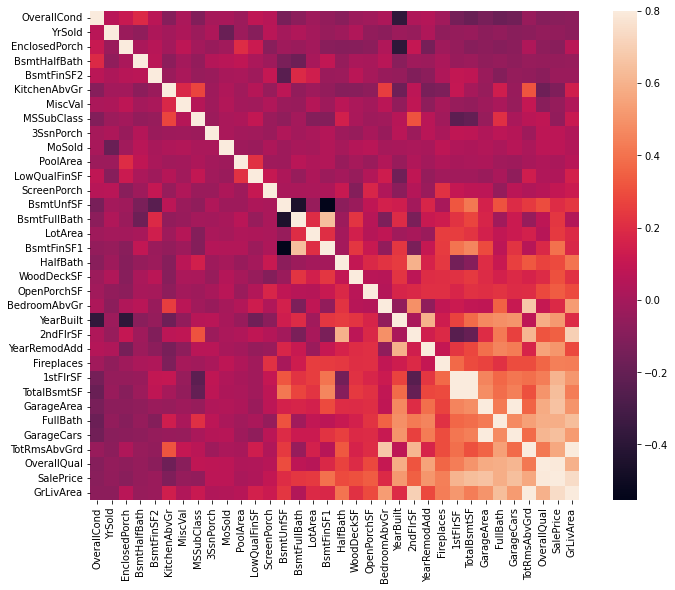

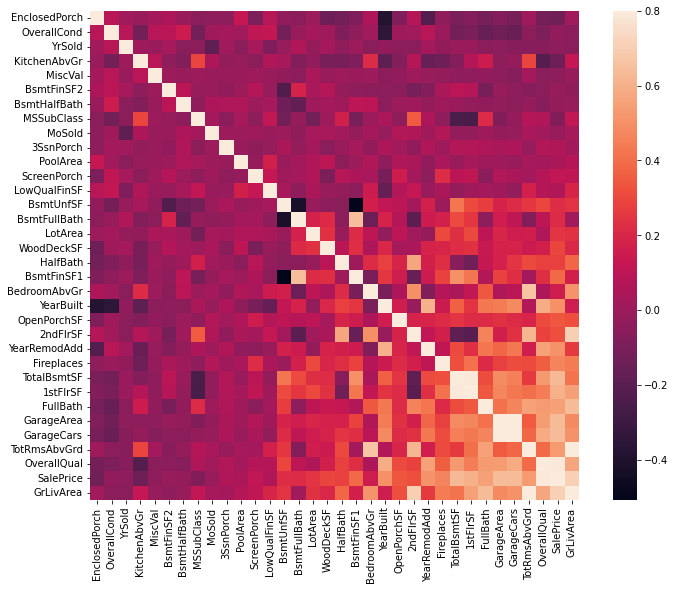

In [116]:
for fold, (index_train, index_val) in enumerate(kf.split(x_train)):
    print(fold, 'idx_train: ',index_train.shape, ' idx_val:',index_val.shape)
    
    corr_target = correlation_heatmap(x_train.iloc[index_train], x_train.columns)
    
    high_corr_features = corr_target[target].sort_values(ascending=False)[1:num_best_features+1].index
    print(np.sort(list(high_corr_features)))
    list_features.append(high_corr_features)
    
    lr = LinearRegression().fit(x_train.iloc[index_train][high_corr_features].values, 
                                x_train.iloc[index_train][[target]].values)
    
    y_predict = lr.predict(x_train.iloc[index_val][high_corr_features].values)
    metric_val = mean_squared_error(y_predict, x_train.iloc[index_val][[target]].values)
    
    list_metrics.append(metric_val)
    print(metric_val)
    print('--------------')

In [117]:
np.mean(list_metrics), np.std(list_metrics)

(1333694150.264698, 401585562.22048634)

In [118]:
# high_corr_features_exp_2 = np.unique(np.hstack(list_features))
high_corr_features_exp_2 = np.unique(list_features)
print(len(high_corr_features_exp_2))
df_last_features = pd.DataFrame(np.sort(high_corr_features_exp_1))
df_last_features[1] = high_corr_features_exp_2
df_last_features.columns = ['exp_1', 'exp_2']
df_last_features
# pd.DataFrame(np.vstack([high_corr_features_exp_1, high_corr_features_exp_2]))

10


,exp_1,exp_2
0,1stFlrSF,1stFlrSF
1,FullBath,FullBath
2,GarageArea,GarageArea
3,GarageCars,GarageCars
4,GrLivArea,GrLivArea
5,OverallQual,OverallQual
6,TotRmsAbvGrd,TotRmsAbvGrd
7,TotalBsmtSF,TotalBsmtSF
8,YearBuilt,YearBuilt
9,YearRemodAdd,YearRemodAdd


In [119]:
## final model experiment_2
lr = LinearRegression().fit(x_train[high_corr_features_exp_2].values, 
                            x_train[[target]].values)    
y_predict_train = lr.predict(x_train[high_corr_features_exp_2].values)
y_predict_test = lr.predict(x_test[high_corr_features_exp_2].values)

metric_train_exp_2 = mean_squared_error(y_predict_train, x_train[[target]].values)
metric_test_exp_2 = mean_squared_error(y_predict_test, x_test[[target]].values)

print('metric train: ', metric_train_exp_2)
print('metric test: ', metric_test_exp_2)

metric train:  1277187727.1978283
metric test:  1766851862.6347868


In [120]:
print('metric train: ', metric_train_exp_1)
print('metric test: ', metric_test_exp_1)

metric train:  1277187727.1978283
metric test:  1766851862.6348188
